<a href="https://colab.research.google.com/github/Adeebakhan123/GenerativeTruss/blob/main/BTP_Final_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab: you probably already have torch; in WSL/Ubuntu run:
!pip install torch torchvision matplotlib numpy


Device: cpu


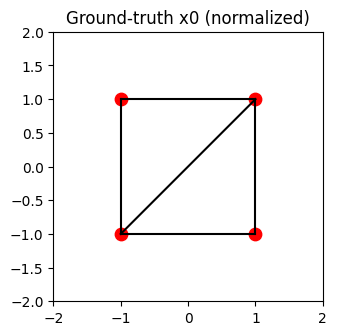

In [ ]:
# STEP 1: basic setup and plot ground-truth truss
import math, os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# reproducibility + device
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# 4-node truss (coordinates in [0,1])
nodes_01 = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0],
], dtype=np.float32)
edges = [(0,1),(1,2),(2,3),(3,0),(0,2)]

# normalize to [-1,1] (common for diffusion models)
x0_np = nodes_01 * 2.0 - 1.0
x0 = torch.tensor(x0_np, dtype=torch.float32).to(DEVICE)  # shape (4,2)

def plot_truss_pts(pts, edges, title=""):
    pts = pts if isinstance(pts, np.ndarray) else pts.detach().cpu().numpy()
    plt.figure(figsize=(3.5,3.5))
    plt.scatter(pts[:,0], pts[:,1], s=80, c='red')
    for i,j in edges:
        p,q = pts[i], pts[j]
        plt.plot([p[0], q[0]], [p[1], q[1]], 'k-', lw=1.5)
    plt.gca().set_aspect('equal', 'box')
    plt.xlim(-2,2); plt.ylim(-2,2)
    plt.title(title)
    plt.show()

plot_truss_pts(x0, edges, "Ground-truth x0 (normalized)")


In [ ]:
# STEP 2: cosine schedule utilities (alpha_bar, alphas, betas)
T = 1000  # total forward steps (can keep default)
def cosine_alpha_bar(T, s=0.008, device=DEVICE):
    steps = torch.arange(T+1, dtype=torch.float64, device=device)  # 0..T
    f = torch.cos(((steps / T) + s) / (1.0 + s) * (math.pi/2.0)) ** 2
    alpha_bar = (f / f[0]).to(torch.float32)
    alpha_bar = torch.clamp(alpha_bar, min=1e-12)  # safe lower bound
   # alpha_bar[-1] = 0.0  # force last to 0 (diagnostic / easier verification)
    return alpha_bar

alpha_bar = cosine_alpha_bar(T)
# compute per-step alpha and beta (not strictly needed for forward sampling but useful)
alphas = torch.zeros(T, dtype=torch.float32, device=DEVICE)
betas = torch.zeros(T, dtype=torch.float32, device=DEVICE)
for t in range(1, T+1):
    a_t = (alpha_bar[t] / alpha_bar[t-1]) if alpha_bar[t-1] > 0 else 0.0
    alphas[t-1] = a_t
    betas[t-1] = 1.0 - a_t

print(" alpha_bar[T]:" ,float(alpha_bar[-1]))
print("betas sample (first 5):", betas[:5].cpu().numpy())


 alpha_bar[T]: 9.999999960041972e-13
betas sample (first 5): [4.1306019e-05 4.6133995e-05 5.0961971e-05 5.5849552e-05 6.0737133e-05]


In [ ]:
alpha_bar_np = alpha_bar.cpu().numpy()
alphas_np = alphas.cpu().numpy()
betas_np = betas.cpu().numpy()


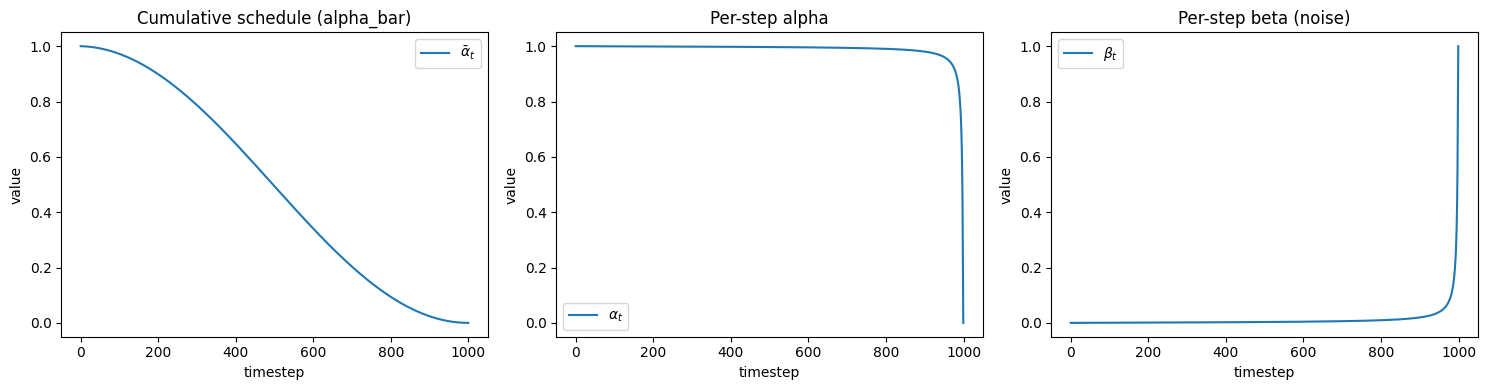

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot alpha_bar
axs[0].plot(alpha_bar_np, label=r"$\bar{\alpha}_t$")
axs[0].set_title("Cumulative schedule (alpha_bar)")
axs[0].set_xlabel("timestep")
axs[0].set_ylabel("value")
axs[0].legend()

# Plot alphas
axs[1].plot(alphas_np, label=r"$\alpha_t$")
axs[1].set_title("Per-step alpha")
axs[1].set_xlabel("timestep")
axs[1].set_ylabel("value")
axs[1].legend()

# Plot betas
axs[2].plot(betas_np, label=r"$\beta_t$")
axs[2].set_title("Per-step beta (noise)")
axs[2].set_xlabel("timestep")
axs[2].set_ylabel("value")
axs[2].legend()

plt.tight_layout()
plt.show()


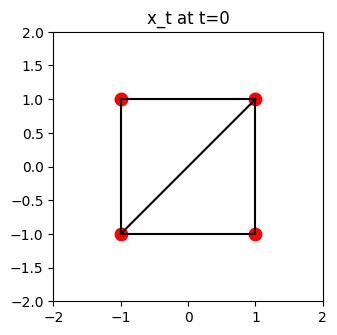

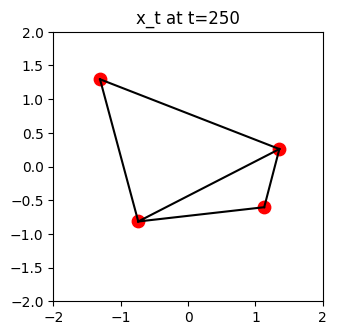

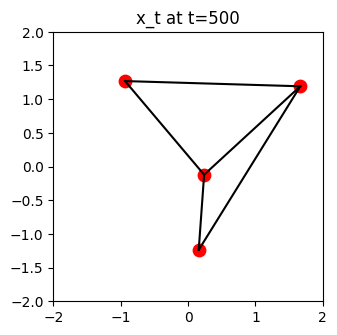

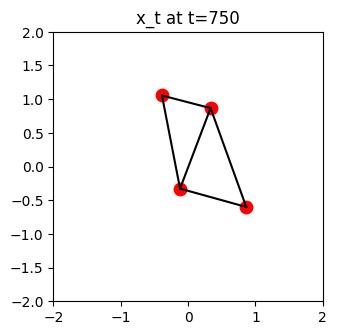

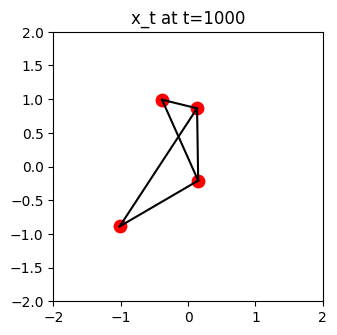

In [ ]:
# STEP 3: vectorized forward sample function and quick demo snapshots
def q_sample(x0_batch, t_tensor):
    """
    x0_batch: (B, N, 2)
    t_tensor: (B,) timesteps (0..T)
    returns: x_t (B,N,2) and eps (B,N,2)
    """
    # index into alpha_bar (length T+1); ensure alpha_bar is on DEVICE
    a_bar_t = alpha_bar[t_tensor].view(-1,1,1)  # (B,1,1)
    mean = torch.sqrt(a_bar_t) * x0_batch
    std  = torch.sqrt(1.0 - a_bar_t)
    eps  = torch.randn_like(x0_batch)
    return mean + std * eps, eps

# demo: show x_t at multiple timesteps for the single x0
x0_batch = x0.unsqueeze(0)  # (1,N,2)
for t in [0, 250, 500, 750, 1000]:
    xt, _ = q_sample(x0_batch, torch.tensor([t], device=DEVICE))
    plot_truss_pts(xt[0], edges, f"x_t at t={t}")


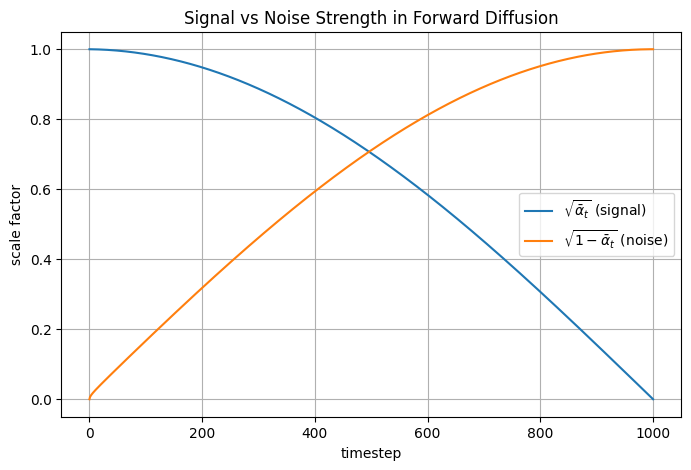

In [ ]:
# Plot signal vs noise strength curves
timesteps = torch.arange(T+1)
signal_strength = torch.sqrt(alpha_bar).cpu()
noise_strength = torch.sqrt(1 - alpha_bar).cpu()

plt.figure(figsize=(8,5))
plt.plot(timesteps, signal_strength, label=r"$\sqrt{\alphā_t}$ (signal)")
plt.plot(timesteps, noise_strength, label=r"$\sqrt{1-\alphā_t}$ (noise)")
plt.xlabel("timestep")
plt.ylabel("scale factor")
plt.title("Signal vs Noise Strength in Forward Diffusion")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# STEP 4: dataset that produces (x_t, t, x0, eps)
class TrussDiffusionDataset(Dataset):
    def __init__(self, x0, T, n_samples=20000, device=DEVICE):
        # x0: (N,2) tensor on device
        self.x0 = x0.unsqueeze(0)   # (1,N,2)
        self.T = T
        self.n_samples = n_samples
        self.device = device

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # sample a random t and produce x_t on the fly
        t = torch.randint(0, self.T+1, (1,), device=self.device).squeeze(0)  # 0..T
        x_t, eps = q_sample(self.x0, t.unsqueeze(0))
        return x_t.squeeze(0), t, self.x0.squeeze(0), eps.squeeze(0)

# instantiate DataLoader
dataset = TrussDiffusionDataset(x0, T, n_samples=10000)
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)
# peek one batch
x_t_b, t_b, x0_b, eps_b = next(iter(loader))
print("Batch shapes:", x_t_b.shape, t_b.shape, x0_b.shape, eps_b.shape)


Batch shapes: torch.Size([128, 4, 2]) torch.Size([128]) torch.Size([128, 4, 2]) torch.Size([128, 4, 2])


In [ ]:
# STEP 5: time embedding and tiny MLP denoiser
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t: (B,)
        # basic sinusoidal embedding scaled by T
        half = self.dim // 2
        t = t.float() / T  # normalize to [0,1]
        freqs = torch.exp(torch.linspace(0, math.log(10000), half, device=t.device))
        args = t.unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = torch.nn.functional.pad(emb, (0,1))
        return emb

class TrussDenoiser(nn.Module):
    def __init__(self, n_nodes=4, t_dim=64, hidden=128):
        super().__init__()
        self.n_nodes = n_nodes
        self.in_dim = n_nodes * 2
        self.t_emb = SinusoidalTimeEmbedding(t_dim)
        self.net = nn.Sequential(
            nn.Linear(self.in_dim + t_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, self.in_dim)
        )

    def forward(self, x_t, t):
        # x_t: (B,N,2)
        B = x_t.shape[0]
        flat = x_t.view(B, -1)
        temb = self.t_emb(t)  # (B, t_dim)
        h = torch.cat([flat, temb], dim=1)
        out = self.net(h)
        return out.view(B, self.n_nodes, 2)

# model to device
model = TrussDenoiser(n_nodes=4, t_dim=64, hidden=128).to(DEVICE)
print(model)


TrussDenoiser(
  (t_emb): SinusoidalTimeEmbedding()
  (net): Sequential(
    (0): Linear(in_features=72, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=8, bias=True)
  )
)


In [ ]:
# STEP 6: train the denoiser with MSE loss (predict eps)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
EPOCHS = 8       # start small; increase later
log_every = 200

global_step = 0
for epoch in range(EPOCHS):
    for x_t_batch, t_batch, x0_batch, eps_batch in loader:
        # move to device (dataset already yields on device but ensure)
        x_t_batch = x_t_batch.to(DEVICE)
        t_batch   = t_batch.to(DEVICE)
        eps_batch = eps_batch.to(DEVICE)

        eps_pred = model(x_t_batch, t_batch)   # predict noise
        loss = criterion(eps_pred, eps_batch)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if global_step % log_every == 0:
            # quick recovery check for first sample in batch
            with torch.no_grad():
                t1 = t_batch[:1]
                xt1 = x_t_batch[:1]
                eps1 = eps_pred[:1]
                a_bar = alpha_bar[t1].view(-1,1,1)
                x0_hat = (xt1 - torch.sqrt(1.0 - a_bar) * eps1) / (torch.sqrt(a_bar) + 1e-12)
                mse_x0 = torch.mean((x0_hat - x0_batch[:1].to(DEVICE))**2).item()
            print(f"epoch {epoch+1}/{EPOCHS} step {global_step} loss={loss.item():.6e} mse_x0={mse_x0:.6e}")
        global_step += 1

print("Training finished.")


epoch 1/8 step 0 loss=9.845062e-01 mse_x0=6.571773e-01
epoch 3/8 step 200 loss=7.462852e-02 mse_x0=5.974474e-03
epoch 6/8 step 400 loss=8.204703e-02 mse_x0=1.343292e-03
epoch 8/8 step 600 loss=7.181132e-02 mse_x0=5.401071e-02
Training finished.


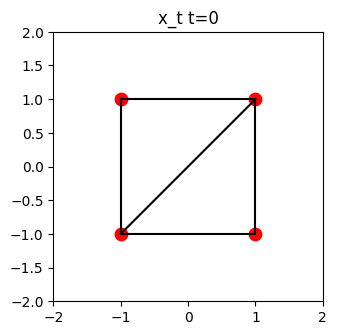

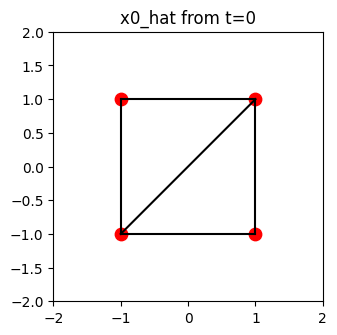

x0_hat stats: -1.0 1.0 0.0


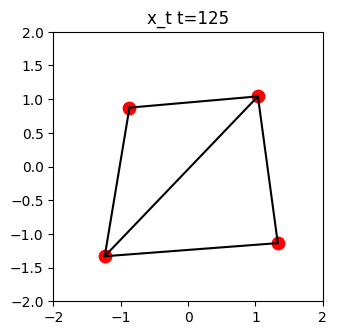

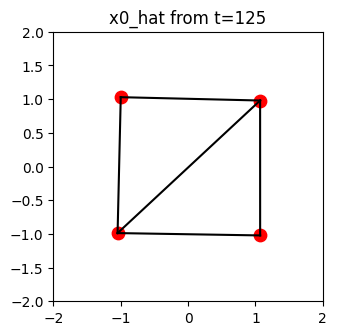

x0_hat stats: -1.046534776687622 1.0693492889404297 0.011339835822582245


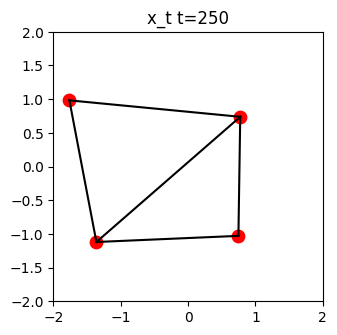

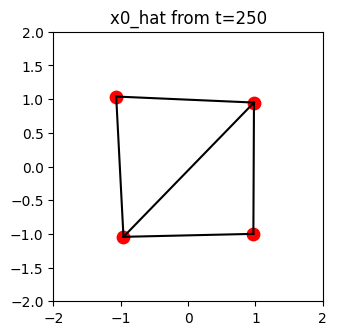

x0_hat stats: -1.0672465562820435 1.0388015508651733 -0.01682199537754059


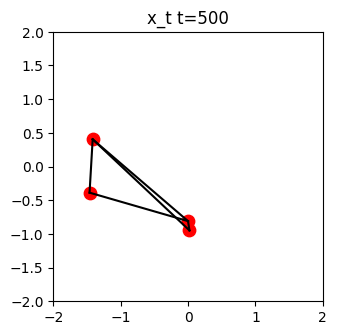

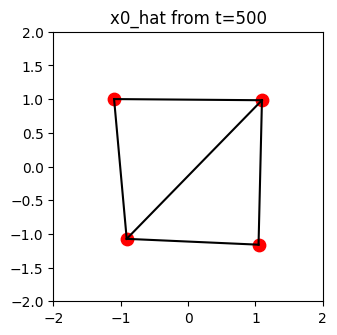

x0_hat stats: -1.159926414489746 1.096277117729187 -0.014502525329589844


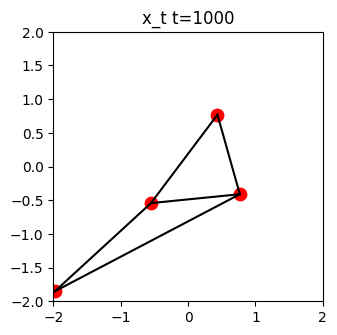

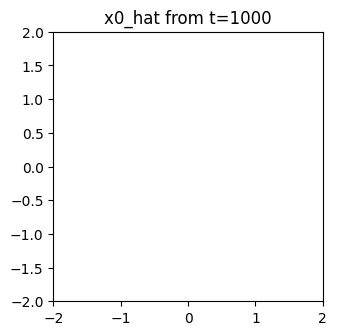

x0_hat stats: -59847.5625 476982.0 138393.375


In [ ]:
# STEP 7: visualize some forward snapshots and x0 reconstructions
model.eval()
with torch.no_grad():
    x0_b = x0.unsqueeze(0)  # (1,N,2)
    #fig, axs = plt.subplots(2,5, figsize=(15,6))
    t_list = [0, 125, 250, 500, 1000]
    for i, t_val in enumerate(t_list):
        xt, eps = q_sample(x0_b, torch.tensor([t_val], device=DEVICE))
        plot_truss_pts(xt[0], edges, title=f"x_t t={t_val}")
        # predict eps and reconstruct x0
        eps_hat = model(xt, torch.tensor([t_val], device=DEVICE))
        a_bar = alpha_bar[torch.tensor([t_val], device=DEVICE)].view(-1,1,1)
        x0_hat = (xt - torch.sqrt(1.0 - a_bar) * eps_hat) / (torch.sqrt(a_bar) + 1e-12)
        plot_truss_pts(x0_hat[0], edges, title=f"x0_hat from t={t_val}")
        print("x0_hat stats:", x0_hat.min().item(), x0_hat.max().item(), x0_hat.mean().item())



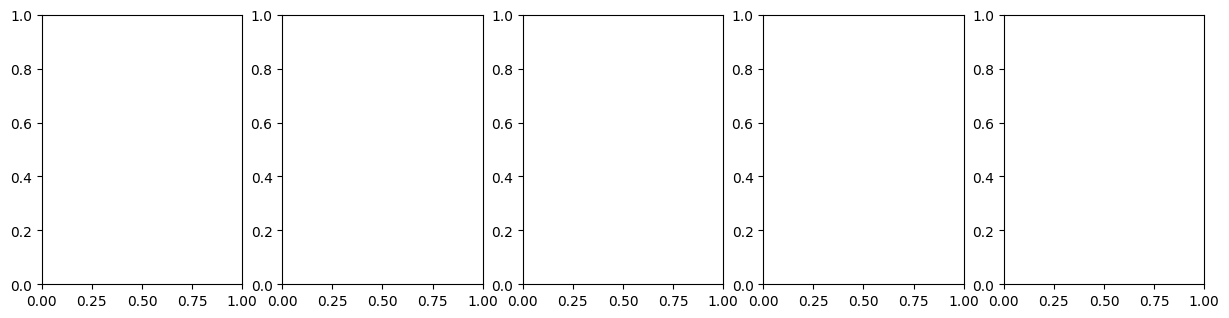

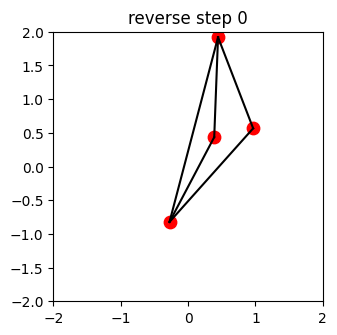

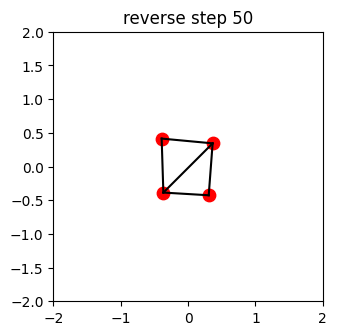

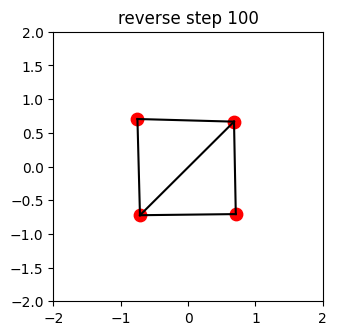

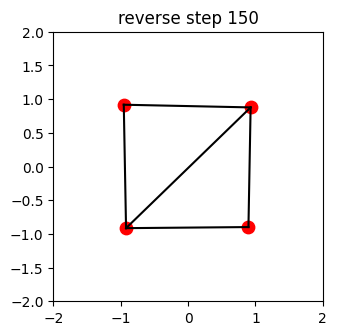

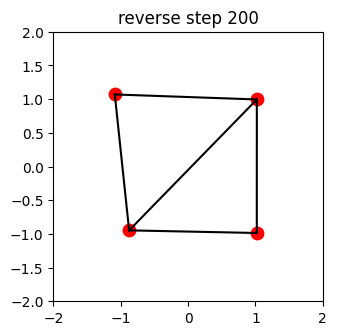

Final MSE from recovered to true x0: 0.003984401002526283


In [ ]:
@torch.no_grad()
def ddim_reverse(model, num_steps=200):
    model.eval()
    ts = torch.linspace(T-1, 0, steps=num_steps, device=DEVICE).long()

    # start from pure noise
    xt = torch.randn((1, x0.shape[0], 2), device=DEVICE)
    traj = [xt[0].cpu().clone()]

    for t_cur in ts:
        t_vec = t_cur.view(1)
        eps_pred = model(xt, t_vec)

        # reconstruct x0
        a_bar_t = alpha_bar[t_vec].view(-1,1,1)
        x0_hat = (xt - torch.sqrt(1.0 - a_bar_t) * eps_pred) / (torch.sqrt(a_bar_t) + 1e-12)

        # move to previous step (deterministic DDIM update)
        a_bar_prev = alpha_bar[t_cur-1] if t_cur > 0 else torch.tensor(1.0, device=DEVICE)
        xt = torch.sqrt(a_bar_prev).view(1,1,1) * x0_hat

        traj.append(xt[0].cpu().clone())

    return traj


trajectory = ddim_reverse(model, num_steps=200)
# visualize 5 frames from the trajectory
idxs = np.linspace(0, len(trajectory)-1, 5, dtype=int)
fig, axs = plt.subplots(1,5,figsize=(15,3.5))
for ax, idx in zip(axs, idxs):
    plot_truss_pts(trajectory[idx], edges, title=f"reverse step {idx}")
# final comparison
print("Final MSE from recovered to true x0:",
      torch.mean((trajectory[-1].to(DEVICE) - x0.to(DEVICE))**2).item())


In [ ]:
@torch.no_grad()
def ddim_reverse(model, num_steps=200):
    model.eval()

    # pick a strictly decreasing subset of *unique* timesteps
    ts = torch.linspace(T-1, 0, steps=num_steps, device=DEVICE)
    ts = torch.round(ts).long()
    ts = torch.unique_consecutive(ts)  # remove accidental duplicates

    # start from noise
    xt = torch.randn((1, x0.shape[0], 2), device=DEVICE)
    traj = [xt[0].cpu().clone()]

    for i, t in enumerate(ts):
        t_vec = t.view(1)

        # predict eps and recover x0_hat at the *current* t
        eps_pred = model(xt, t_vec)
        a_bar_t = alpha_bar[t].view(1,1,1)
        x0_hat = (xt - torch.sqrt(1.0 - a_bar_t) * eps_pred) / (torch.sqrt(a_bar_t) + 1e-12)
        # optional safety: keep geometry in range
        x0_hat = x0_hat.clamp(-1, 1)

        # use the *previous selected* timestep, not (t-1)
        if i == len(ts) - 1:
            # final step → land exactly on x0_hat
            xt = x0_hat
        else:
            t_prev = ts[i+1]
            a_bar_prev = alpha_bar[t_prev].view(1,1,1)

            # DDIM (η=0): deterministic step
            # You can use either of these; try (A) first.
            # (A) "x0-only" update (very stable):
            xt = torch.sqrt(a_bar_prev) * x0_hat

            # (B) classic DDIM direction term (often fine too):
            # xt = torch.sqrt(a_bar_prev) * x0_hat + torch.sqrt(1.0 - a_bar_prev) * eps_pred

        traj.append(xt[0].detach().cpu().clone())

    return traj


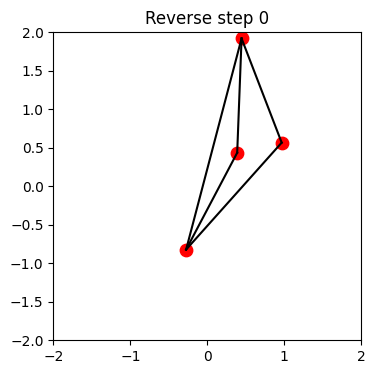

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Create the figure
fig, ax = plt.subplots(figsize=(4,4))

def update(i):
    ax.clear()
    pts = trajectory[i].numpy()
    ax.scatter(pts[:,0], pts[:,1], s=80, c='red')
    for p, q in edges:
        ax.plot([pts[p,0], pts[q,0]], [pts[p,1], pts[q,1]], 'k-', lw=1.5)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Reverse step {i}")

# Build animation (100ms per frame → 10 fps)
ani = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=100)

# Show inline in Colab
HTML(ani.to_jshtml())
